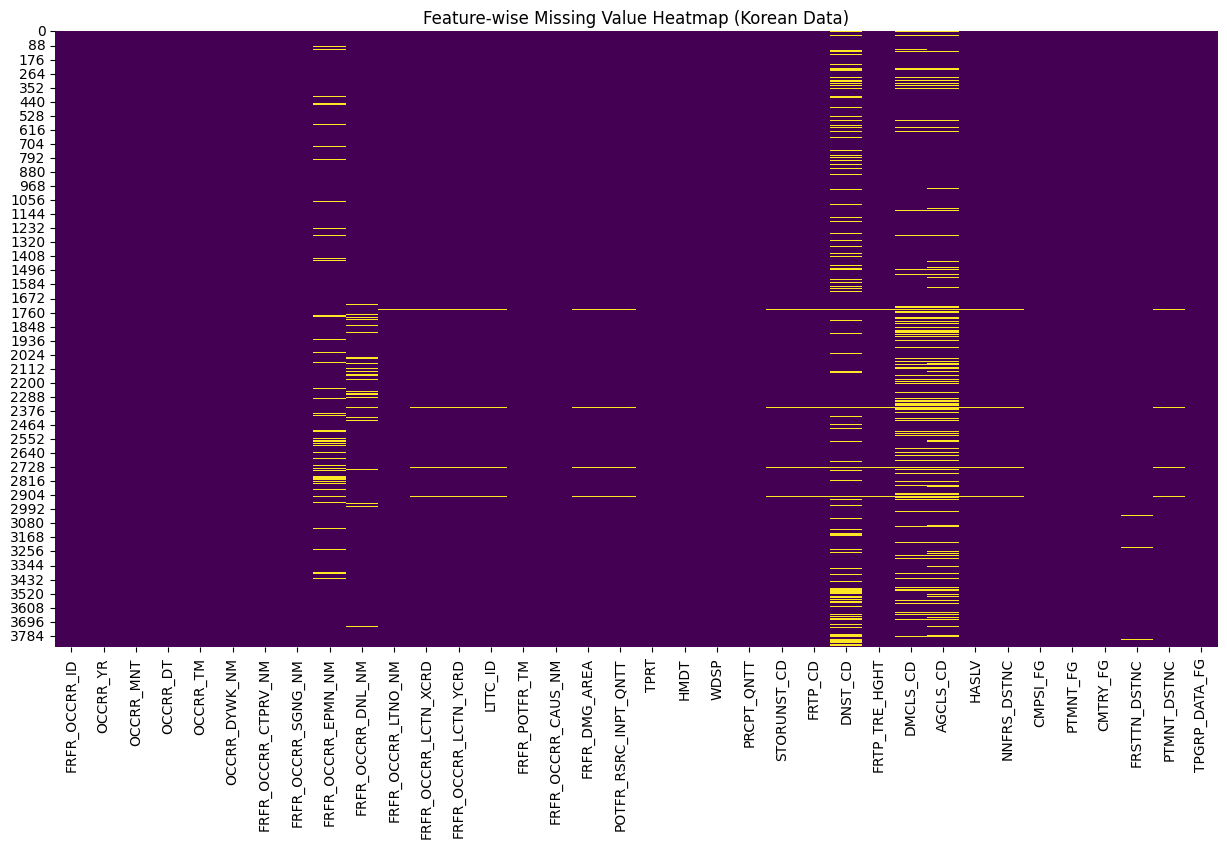

컬럼별 결측치 비율:
 AGCLS_CD                20.041483
DNST_CD                 17.137672
DMCLS_CD                16.385792
FRFR_OCCRR_EPMN_NM       7.829920
FRFR_OCCRR_DNL_NM        3.837179
FRFR_OCCRR_LCTN_XCRD     1.037075
FRFR_OCCRR_LCTN_YCRD     1.037075
FRTP_TRE_HGHT            1.037075
POTFR_RSRC_INPT_QNTT     1.037075
FRFR_DMG_AREA            1.037075
HASLV                    1.037075
LTTC_ID                  1.037075
FRTP_CD                  1.037075
STORUNST_CD              1.037075
NNFRS_DSTNC              1.037075
PTMNT_DSTNC              1.037075
FRSTTN_DSTNC             0.388903
FRFR_OCCRR_LTNO_NM       0.025927
CMPSI_FG                 0.000000
PTMNT_FG                 0.000000
CMTRY_FG                 0.000000
FRFR_OCCRR_ID            0.000000
TPRT                     0.000000
PRCPT_QNTT               0.000000
WDSP                     0.000000
HMDT                     0.000000
OCCRR_YR                 0.000000
FRFR_OCCRR_CAUS_NM       0.000000
FRFR_POTFR_TM            0.000000
F

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 로드 (경로는 실제 파일 위치로 수정)
df_korea = pd.read_csv('datasets/WSQ000301.csv', encoding='UTF-8') #datasets\WSQ000301.csv

plt.figure(figsize=(15, 8))
sns.heatmap(df_korea.isnull(), cbar=False, cmap='viridis')
plt.title('Feature-wise Missing Value Heatmap (Korean Data)')
plt.show()

# 결측치 비율 출력
print("컬럼별 결측치 비율:\n", (df_korea.isnull().sum() / len(df_korea) * 100).sort_values(ascending=False))


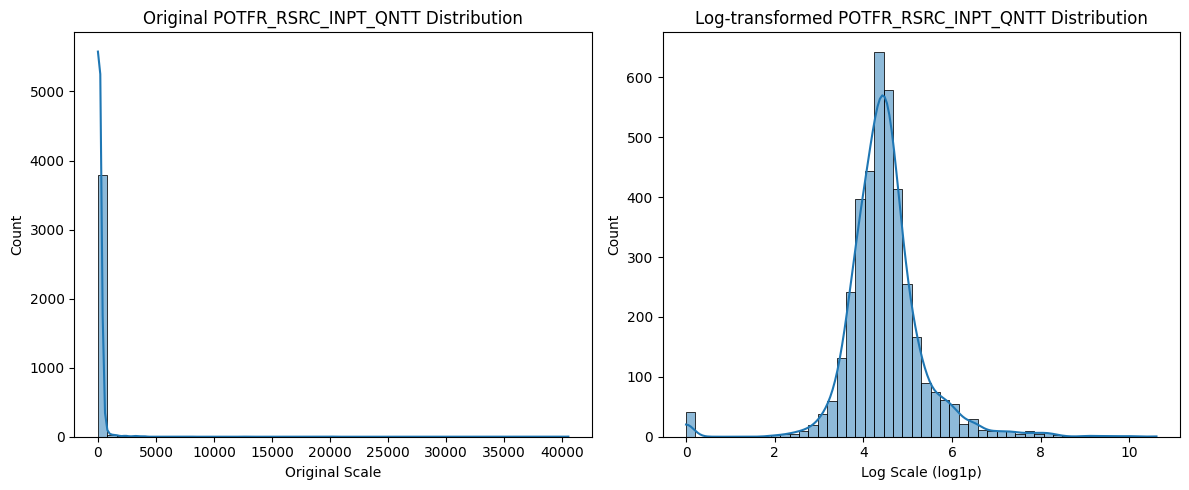

원본 'POTFR_RSRC_INPT_QNTT' 왜도: 28.40, 첨도: 1012.60
로그변환 'POTFR_RSRC_INPT_QNTT' 왜도: -0.15, 첨도: 8.71


In [3]:
import numpy as np

target_col = 'POTFR_RSRC_INPT_QNTT' # [1]
df_korea[target_col] = pd.to_numeric(df_korea[target_col], errors='coerce').fillna(0)
df_korea[target_col] = df_korea[target_col].apply(lambda x: max(x, 0))

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df_korea[target_col], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Original POTFR_RSRC_INPT_QNTT Distribution')
axes[0].set_xlabel('Original Scale')

df_korea['log_' + target_col] = np.log1p(df_korea[target_col])
sns.histplot(df_korea['log_' + target_col], kde=True, ax=axes[1], bins=50)
axes[1].set_title('Log-transformed POTFR_RSRC_INPT_QNTT Distribution')
axes[1].set_xlabel('Log Scale (log1p)')
plt.tight_layout()
plt.show()

print(f"원본 '{target_col}' 왜도: {df_korea[target_col].skew():.2f}, 첨도: {df_korea[target_col].kurt():.2f}")
print(f"로그변환 '{target_col}' 왜도: {df_korea['log_' + target_col].skew():.2f}, 첨도: {df_korea['log_' + target_col].kurt():.2f}")


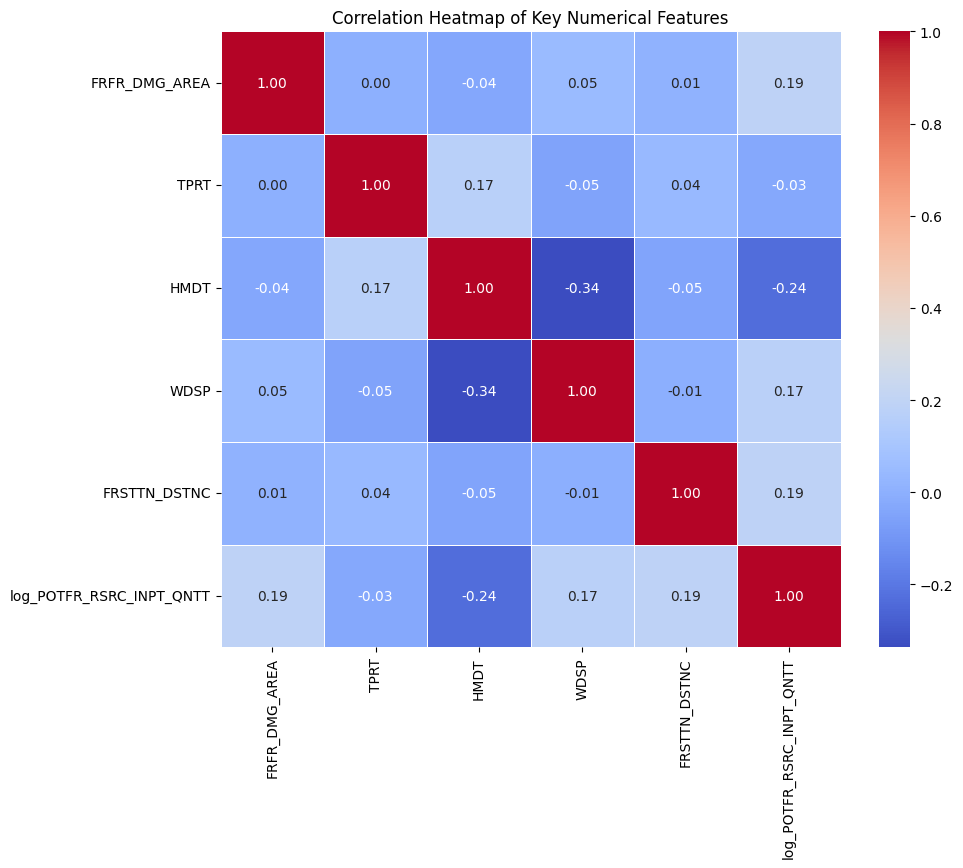

In [4]:
numeric_cols_for_corr = ['FRFR_DMG_AREA', 'TPRT', 'HMDT', 'WDSP', 'FRSTTN_DSTNC', 'log_' + target_col] # [1]
# 필요한 전처리 (결측치 처리 등) 후 상관계수 계산
df_corr_subset = df_korea[numeric_cols_for_corr].copy()
for col in numeric_cols_for_corr: # 간단한 숫자 변환 및 결측치 처리
    df_corr_subset[col] = pd.to_numeric(df_corr_subset[col], errors='coerce')
df_corr_subset = df_corr_subset.fillna(df_corr_subset.median()) # 예시: 중앙값으로 대체

correlation_matrix = df_corr_subset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Key Numerical Features')
plt.show()


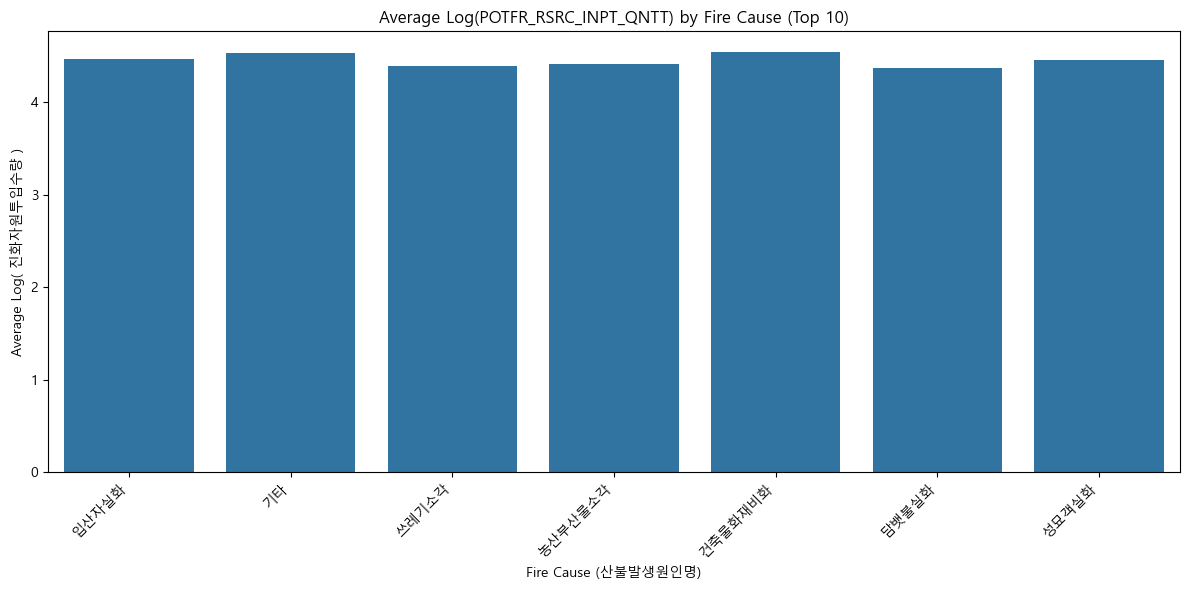

In [6]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

plt.figure(figsize=(12, 6))

# FRFR_OCCRR_CAUS_NM [1] 컬럼의 고유값이 너무 많으면 상위 N개만 시각화
top_n_causes = df_korea['FRFR_OCCRR_CAUS_NM'].value_counts().nlargest(10).index
df_top_causes = df_korea[df_korea['FRFR_OCCRR_CAUS_NM'].isin(top_n_causes)]

sns.barplot(x='FRFR_OCCRR_CAUS_NM', y='log_' + target_col, data=df_top_causes, estimator=np.mean, errorbar=None, order=top_n_causes)
plt.title('Average Log(POTFR_RSRC_INPT_QNTT) by Fire Cause (Top 10)')
plt.xlabel('Fire Cause (산불발생원인명)')
plt.ylabel('Average Log( 진화자원투입수량 )')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


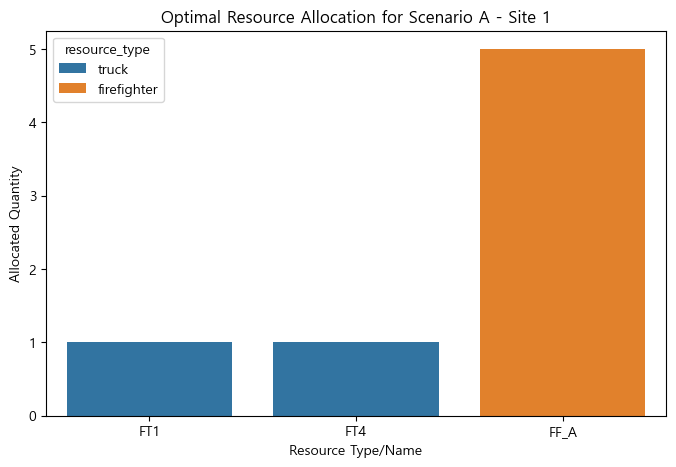

In [7]:
allocation_results_scenA_site1 = [
    {'type': 'FT1', 'quantity': 1, 'resource_type': 'truck'},
    {'type': 'FT4', 'quantity': 1, 'resource_type': 'truck'},
    {'type': 'FF_A', 'quantity': 5, 'resource_type': 'firefighter'}
]
df_alloc = pd.DataFrame(allocation_results_scenA_site1)
plt.figure(figsize=(8, 5))
sns.barplot(x='type', y='quantity', hue='resource_type', data=df_alloc, dodge=False)
plt.title('Optimal Resource Allocation for Scenario A - Site 1')
plt.xlabel('Resource Type/Name')
plt.ylabel('Allocated Quantity')
plt.show()